# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
# tf.keras.backend.set_floatx('float32')

# Loading Dataset

In [2]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")
train_df = train_df.reindex(np.random.permutation(train_df.index))

# Normalize Features 

In [3]:
train_df_mean = train_df.mean()
train_df_std = train_df.std()
train_df_norm = (train_df - train_df_mean)/train_df_std

train_df_norm.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
16952,-2.3,2.4,1.5,-0.5,-0.5,-0.6,-0.4,-1.1,-1.1
580,1.3,-1.3,-0.1,-0.3,-0.5,-0.4,-0.5,0.1,-0.4
7967,0.6,-0.7,1.6,-0.9,-1.1,-1.0,-1.0,2.2,2.5
12116,-0.9,1.4,-0.8,-0.4,-0.2,-0.5,-0.5,-1.4,-1.2
15710,-1.4,0.9,0.6,-0.4,-0.1,-0.2,-0.1,-0.7,0.6


In [5]:
test_df_mean = test_df.mean()
test_df_std  = test_df.std()
test_df_norm = (test_df - test_df_mean)/test_df_std

In [6]:
threshold = 265000
train_df_norm["median_house_value_is_high"] = (train_df["median_house_value"] > threshold).astype(float)
test_df_norm["median_house_value_is_high"] = (test_df["median_house_value"] > threshold).astype(float) 
train_df_norm["median_house_value_is_high"].head(8000)

16952   0.0
580     0.0
7967    1.0
12116   0.0
15710   1.0
         ..
7724    1.0
13074   0.0
8302    1.0
15327   0.0
6099    0.0
Name: median_house_value_is_high, Length: 8000, dtype: float64

In [7]:
feature_columns = []

#representing median_income.
median_income = tf.feature_column.numeric_column("median_income")
feature_columns.append(median_income)

#representing total_rooms.
tr = tf.feature_column.numeric_column("total_rooms")
feature_columns.append(tr)

# Convert the list of feature columns into a layer that will later be fed into
# the model. 
feature_layer = layers.DenseFeatures(feature_columns)


feature_layer(dict(train_df_norm))

<tf.Tensor: shape=(17000, 2), dtype=float32, numpy=
array([[-1.1155155 , -0.53105164],
       [ 0.0953915 , -0.3182024 ],
       [ 2.169802  , -0.9370248 ],
       ...,
       [ 1.4153566 ,  0.6116367 ],
       [-0.51849943, -0.5260056 ],
       [-0.75029385, -0.65995383]], dtype=float32)>

# traning model

In [11]:
def create_model(my_learning_rate, feature_layer, my_metrics):
    
    model = tf.keras.models.Sequential()
    
    model.add(feature_layer)

    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid),)

  
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)

    return model        


def train_model(model, dataset, epochs, label_name,
                batch_size=None, shuffle=True):
    
  
    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name)) 
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle)
  
    epochs = history.epoch


    hist = pd.DataFrame(history.history)

    return epochs, hist   

#  plotting function

In [12]:
def plot_curve(epochs, hist, list_of_metrics):
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")

    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m)
    plt.legend()

/home/nikhil/anaconda3/envs/deepl/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
170/170 [==============================] - 2s 2ms/step - loss: 0.5306 - accuracy: 0.5893
Epoch 2/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4942 - accuracy: 0.6454
Epoch 3/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4663 - accuracy: 0.6861
Epoch 4/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4445 - accuracy: 0.7187
Epoch 5/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4271 - accuracy: 0.7455
Epoch 6/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4148 - accuracy: 0.7661
Epoch 7/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4064 - accuracy: 0.7828
Epoch 8/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4013 - accuracy: 0.7936
Epoch 9/20
170/170 [==============================] - 0s 2ms/step - loss: 0.3987 - accurac

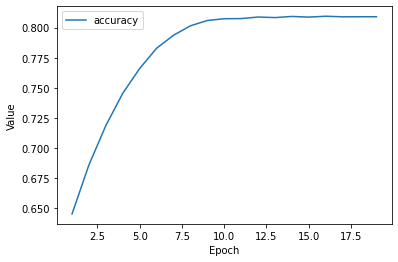

In [13]:
learning_rate = 0.001
epochs = 20
batch_size = 100
label_name = "median_house_value_is_high"
classification_threshold = 0.35


METRICS = [
           tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                           threshold=classification_threshold),
          ]


my_model = create_model(learning_rate, feature_layer, METRICS)


epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)


list_of_metrics_to_plot = ['accuracy'] 

plot_curve(epochs, hist, list_of_metrics_to_plot)

# Evaluate the model

In [14]:
features = {name:np.array(value) for name, value in test_df_norm.items()}
label = np.array(features.pop(label_name))

my_model.evaluate(x = features, y = label, batch_size=batch_size)

Consider rewriting this model with the Functional API.
30/30 [==============================] - 0s 1ms/step - loss: 0.4069 - accuracy: 0.8007


[0.4068853259086609, 0.8006666898727417]

# Improving model
## Add precision and recall as metrics

Epoch 1/20
Consider rewriting this model with the Functional API.


/home/nikhil/anaconda3/envs/deepl/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Consider rewriting this model with the Functional API.
170/170 [==============================] - 1s 2ms/step - loss: 0.8053 - accuracy: 0.2799 - precision: 0.2224 - recall: 0.7539
Epoch 2/20
170/170 [==============================] - 0s 2ms/step - loss: 0.6970 - accuracy: 0.3062 - precision: 0.2369 - recall: 0.8001
Epoch 3/20
170/170 [==============================] - 0s 2ms/step - loss: 0.6084 - accuracy: 0.3746 - precision: 0.2595 - recall: 0.8112
Epoch 4/20
170/170 [==============================] - 0s 2ms/step - loss: 0.5391 - accuracy: 0.6038 - precision: 0.3613 - recall: 0.7629
Epoch 5/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4886 - accuracy: 0.7558 - precision: 0.5083 - recall: 0.6847
Epoch 6/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4538 - accuracy: 0.7961 - precision: 0.5832 - recall: 0.6445
Epoch 7/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4319 - accuracy: 0.8070 - precision: 0.6115 - recall: 0.62

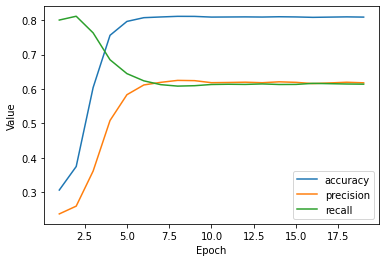

In [15]:
learning_rate = 0.001
epochs = 20
batch_size = 100
classification_threshold = 0.35
label_name = "median_house_value_is_high"


METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                      threshold=classification_threshold),
      tf.keras.metrics.Precision(thresholds=classification_threshold,
                                 name='precision' 
                                 ),
      tf.keras.metrics.Recall(thresholds=classification_threshold,
                              name="recall"),
]


my_model = create_model(learning_rate, feature_layer, METRICS)


epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)


list_of_metrics_to_plot = ['accuracy', "precision", "recall"] 
plot_curve(epochs, hist, list_of_metrics_to_plot)

# adding classification threshold

Epoch 1/20
Consider rewriting this model with the Functional API.


/home/nikhil/anaconda3/envs/deepl/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Consider rewriting this model with the Functional API.
170/170 [==============================] - 1s 2ms/step - loss: 0.5937 - accuracy: 0.7330 - precision: 0.4754 - recall: 0.6652
Epoch 2/20
170/170 [==============================] - 0s 2ms/step - loss: 0.5291 - accuracy: 0.7856 - precision: 0.5647 - recall: 0.6193
Epoch 3/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4830 - accuracy: 0.8081 - precision: 0.6229 - recall: 0.5877
Epoch 4/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4513 - accuracy: 0.8185 - precision: 0.6580 - recall: 0.5693
Epoch 5/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4304 - accuracy: 0.8258 - precision: 0.6881 - recall: 0.5533
Epoch 6/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4163 - accuracy: 0.8301 - precision: 0.7146 - recall: 0.5324
Epoch 7/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4075 - accuracy: 0.8326 - precision: 0.7403 - recall: 0.50

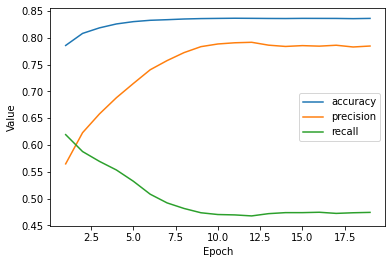

In [16]:
learning_rate = 0.001
epochs = 20
batch_size = 100
classification_threshold = 0.52
label_name = "median_house_value_is_high"


METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                      threshold=classification_threshold),
      tf.keras.metrics.Precision(thresholds=classification_threshold,
                                 name='precision' 
                                 ),
      tf.keras.metrics.Recall(thresholds=classification_threshold,
                              name="recall"),
]


my_model = create_model(learning_rate, feature_layer, METRICS)


epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', "precision", "recall"] 
plot_curve(epochs, hist, list_of_metrics_to_plot)

#  Summarizing model

Epoch 1/20
Consider rewriting this model with the Functional API.


/home/nikhil/anaconda3/envs/deepl/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Consider rewriting this model with the Functional API.
170/170 [==============================] - 1s 2ms/step - loss: 0.8484 - auc: 0.2451
Epoch 2/20
170/170 [==============================] - 0s 2ms/step - loss: 0.7347 - auc: 0.2743
Epoch 3/20
170/170 [==============================] - 0s 2ms/step - loss: 0.6411 - auc: 0.4009
Epoch 4/20
170/170 [==============================] - 0s 2ms/step - loss: 0.5680 - auc: 0.6970
Epoch 5/20
170/170 [==============================] - 0s 2ms/step - loss: 0.5138 - auc: 0.8251
Epoch 6/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4765 - auc: 0.8342
Epoch 7/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4514 - auc: 0.8336
Epoch 8/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4336 - auc: 0.8346
Epoch 9/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4208 - auc: 0.8356
Epoch 10/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4117 - auc: 0.8360
Epoch

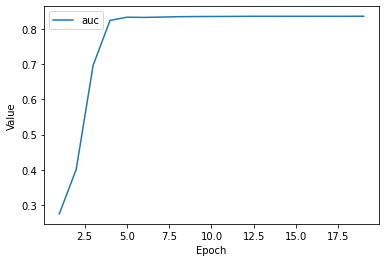

In [17]:
learning_rate = 0.001
epochs = 20
batch_size = 100
label_name = "median_house_value_is_high"

# measure AUC:
METRICS = [
      tf.keras.metrics.AUC(num_thresholds=100, name='auc'),
]

my_model = create_model(learning_rate, feature_layer, METRICS)


epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)


list_of_metrics_to_plot = ['auc'] 
plot_curve(epochs, hist, list_of_metrics_to_plot)